# 1. 고객 세그먼테이션의 정의와 기법

- 고객 세그멘테이션(Customer Segmentaion)은 다양한 기준으로 고객을 분류하는 기법을 지칭  
- 고객을 분류하는 요소는 지역/결혼 여부/ 성별/ 소득과 같이 개인의 신상 데이터를 포함하여 여러가지가 있다.  
- 기업 입장에서는 얼마나 많은 매출을 발생하느냐가 고객 기준을 정하는 주 요소 중 하나

<br>

- 고객 세그멘테이션의 주요 목표는 타깃 마케팅
    - 타깃 마케팅이란 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공하는 것
- 고객 세그먼테이션은 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요
- 그중 기본적인 고객 분성인 RFM 기법을 사용할 예정
    - Recency(새로운, 최신): 가장 최근 상품 구입 일에서 오늘까지의 기간
    - Frequency(빈도): 상품 구매 횟수
    - Monetary Value(화폐 가치): 총 구매 금액

# 2. 데이터 세트 로딩과 데이터 클렌징
- 이 데이터 세트는 제품 주문 데이터 세트
- Invoice(주문번호) + StockCode(제품코드)를 기반으로 주문량, 주문 일자, 제품 단가, 주문 고객 번호, 주문 고객 국가등의 컬럼으로 구성돼 있다.
    - InvoiceNo: 주문번호. 'C'로 시작하는 것은 취소 주문
    - StockCode: 제품 코드(Item Code)
    - Description: 제품 설명
    - Quantity: 주문 제품 건수
    - InvoiceDate: 주문 일자
    - UnitPrice: 제품 단가
    - CustomerID: 고객 번호
    - Country: 국가명(주문 고객의 국적)

In [33]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

retail_df= pd.read_excel(io=r'D:\Python\Online Retail.xlsx')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [34]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- 전체 데이터 수: 541909 
- CustomerID에 Null값이 많음
    - Null 데이터 제거: CustomerID는 고객 식별 번호이지만 고객 세그먼테이션을 수행하는 데에 있어 이는 필요 없기에 삭제
    - 오류 데이터 삭제: 대표적인 오류 데이터는 Quantity 또는 UnitPrice가 0보다 작은 경우  
    사실 Quantity가 0보다 작은 경우는 오류 데이터라기보단 반환을 뜻하는 값  
    이 경우 InvoiceNo의 앞자기는 'C'로 돼 있음.  
    분석의 효율성을 위해서 이 데이터를 모두 삭제

In [35]:
# 불린 인덱싱을 적용해 Quantity >0, UnitPrice > 0이고 CustomerID가 Not Null인 값만 필터링
retail_df= retail_df[retail_df['Quantity'] > 0]
retail_df= retail_df[retail_df['UnitPrice'] > 0]
retail_df= retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [36]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [37]:
# 영국이 대다수를 차지하므로 다른 국가의 데이터는 모두 제외
retail_df= retail_df[retail_df['Country']=='United Kingdom']

# 3. RFM 기반 데이터 가공
- 'UnitPrice'와 'Quantity'를 곱해서 주문 금액 데이터를 생성
- 'CustomerNo'도 식별성을 위해 float형을 int형으로 변경

In [38]:
retail_df['sale_amount']= retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID']= retail_df['CustomerID'].astype(int)

- 해당 온라인 판매 데이터 세트는 주문 횟수와 주문 금액이 압도적으로 특정 고객에게 많은 특성을 가지고 있다.
- 개인 고객의 주문과 소매점의 주문이 함께 포함돼 있기 때문
- Top-5 주문 건수와 주문 금액을 가진 고객 데이터를 추출

In [39]:
print(retail_df['CustomerID'].value_counts().head())
retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5]

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64


CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64

In [40]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [46]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

- RFM 기반의 고객 세그먼테이션은 고객 레벨로 주문기간, 주문 횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션을 수행하려는 것이 목적
- 이에 주문 번호 + 상품 코드 기준의 데이터를 기준으로 Recency, Frequency, Monetary value 데이터로 변경
- 이를 위해서는 주문 번호 기준의 데이터를 개별 고객 기준의 데이터로 Groupby를 해야 함

In [49]:
# DataFrame의 groupby()의 multiple연산을 위해 agg( ) 이용
# Recency는 InvoiceDate 칼럼의 max( )에서 데이터 가공
# Frequency는 InvoiceNo 칼럼이 count( ), Monetary value는 sale_amount 칼럼의 sum()

aggregations={
    'InvoiceDate':'max',
    'InvoiceNo':'count',
    'sale_amount':'sum'
}

cust_df= retail_df.groupby('CustomerID').agg(aggregations)

# groupby된 결과 컬럼 값을 Recency, Frequency, Monetary로 변경
cust_df= cust_df.rename(columns={'InvoiceDate':'Recency',
                                 'InvoiceNo':'Frequency',
                                 'sale_amount':'Monetary'})
cust_df= cust_df.reset_index()
print(cust_df.shape)
cust_df.head()

(3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34


- Recency 컬럼은 개별 고객당 가장 최근의 주문인데, 데이터 값의 특성으로 인해 가공이 필요함
- Recency는 고객이 가장 최근에 주문한 날짜를 기반으로 하는데, 오늘 날짜를 기준으로 가장 최근 주문 일자를 뺀 날짜임
- 2011년 12월 10일을 현재 날짜로 간주하고 가장 최근의 주문 일자를 뺀 데이터에서 일자 데이터(days)만 추출해 생성함

In [50]:
import datetime as dt

cust_df['Recency']= dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency']= cust_df['Recency'].apply(lambda x: x.days+1)
print(cust_df.shape)
cust_df.head()

(3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34


# 4. RFM 기반 고객 세그먼테이션
- 온라인 판매 데이터 세트는 소매업체의 대규모 주문을 포함하고 있다.
- 이들은 개인 고객 주문과 매우 큰 차이를 나타내고 있어 왜곡된 데이터 분포도를 가지게 된다.
- 이는 군집화가 한쪽 군집에만 집중되는 현상을 일으킴

<br>

- 온라인 판매 데이터 세트의 컬럼별 히스토그램을 확인하고, 이처럼 왜곡된 데이터 분포도에서 군집화를 수행할 시 어떤 현상이 일어나는지를 확인

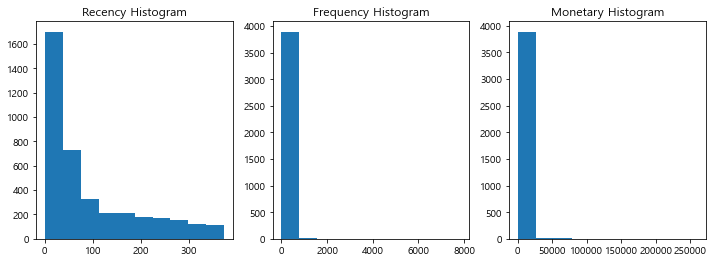

In [53]:
fig, (ax1, ax2, ax3)= plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary']);

In [54]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


Recency, Frequency, Monetary 모두 왜곡된 데이터 값 분포도를 가지고 있음  
- Recency
    - 평균이 91.7이지만 50%(중위값 2/4분위)인 50보다 크게 높음
    - max 값이 373으로 75%인 143보다 훨씬 커서 왜곡 정도가 높음을 알 수 있음
- Frequency
    - 평균이 90.3인데 75%인 99.25에 가까움
    - max값은 7847로 75%보다도 훨씬 높음
- Monetary
    - 평균이 1864.4으로 75%인 1576.5보다 매우 큼
    - 이는 max값 259657.3을 포함한 상위 몇개의 큰 값으로 인해 발생한 현상
    
<br>

왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행 됨

In [63]:
def visualize_silhouette(cluster_lists, X_features):
    from sklearn.datasets import make_blobs
    from sklearn.metrics import silhouette_samples, silhouette_score
    
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    n_cols= len(cluster_lists)
    fig, axs= plt.subplots(figsize= (n_cols* 4, 4), nrows= 1, ncols= n_cols)
    
    for ind, n_cluster in enumerate(cluster_lists):
        
        clusterer= KMeans(n_clusters= n_cluster, max_iter= 500, random_state= 0)
        cluster_labels= clusterer.fit_predict(X_features)
        
        sil_avg= silhouette_score(X_features, cluster_labels)
        sil_values= silhouette_samples(X_features, cluster_labels)
        
        y_lower= 10
        axs[ind].set_title('Number of Cluster: ' + str(n_cluster) + '\n' \
                           'Silhouette Score: ' + str(round(sil_avg, 3)))
        axs[ind].set_xlabel('The silhouette coefficient values')
        axs[ind].set_ylabel('Cluster label')
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, .2, .4, .6, .8, 1])
        
        for i in range(n_cluster):
            ith_cluster_sil_values= sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i= ith_cluster_sil_values.shape[0]
            y_upper= y_lower + size_cluster_i
            
            color= cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx( np.arange(y_lower, y_upper), 0,
                                    ith_cluster_sil_values, facecolor= color, 
                                    edgecolor= color, alpha= 0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower= y_upper + 10
            
        axs[ind].axvline(x= sil_avg, color='red', linestyle= '--')

In [65]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features= cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled= StandardScaler().fit_transform(X_features)

kmeans= KMeans(n_clusters= 3, random_state= 0)
labels= kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']= labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.592


군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어가 0.592로 안정적으로 나옴   
하지만 이걸로는 충분하지 않고 군집별 실루엣 계수에 대해서도 생각해봐야 함

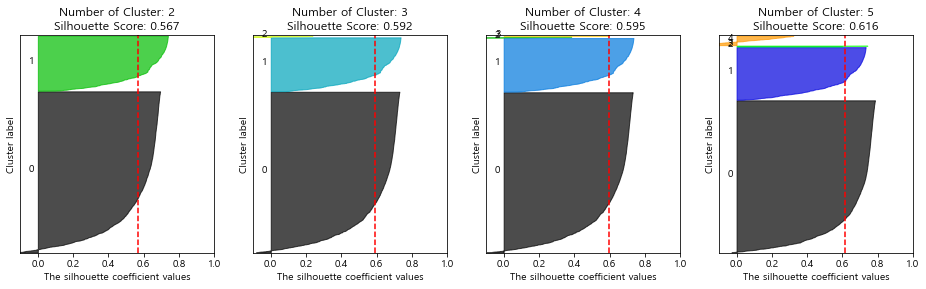

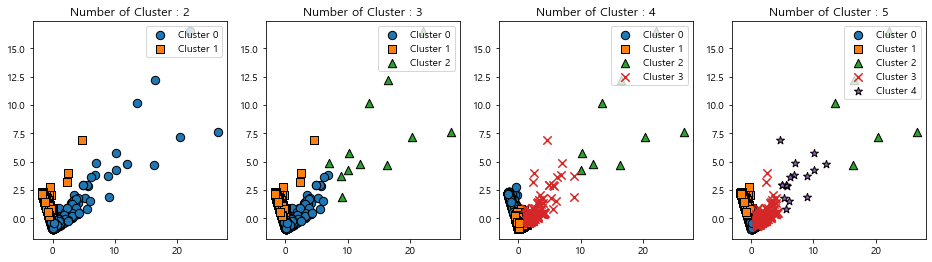

In [66]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

- 군집을 2개로 할 경우 1번 군집이 너무 개괄적으로 나옴
- 그렇지만 군집 수를 증가시켜도 개선이 되지 않음
    - 군집 3개 이상일 때부터 데이터 세트의 개수가 너무 작은 군집이 발생
    - 실루엣 계수 역시 상대적으로 작게 나옴
- 이 데이터 세트의 경우 데이터 값이 거리 기반으로 광범위하게 퍼져 있어서 군집 수를 계속 늘려봐야 이 군집만 지속적으로 분리하게 되기에 의미 없는 결과로 이어짐
- 이런 경우( 데이터가 한곳으로 치우쳐져 있는 ) 로그변환을 이용하는 것이 좋음

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequency, Monetary 컬럼에 np.log1p()로 Log Transformation
cust_df['Recency_log']= np.log1p(cust_df['Recency'])
cust_df['Frequency_log']= np.log1p(cust_df['Frequency'])
cust_df['Monetary_log']= np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features= cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_feature_scaled= StandardScaler().fit_transform(X_features)

kmeans= KMeans(n_clusters=3, random_state=0)
labels= kmeans.fit_predict(X_features_scaled)

cust_df['cluster_label']= labels
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.592


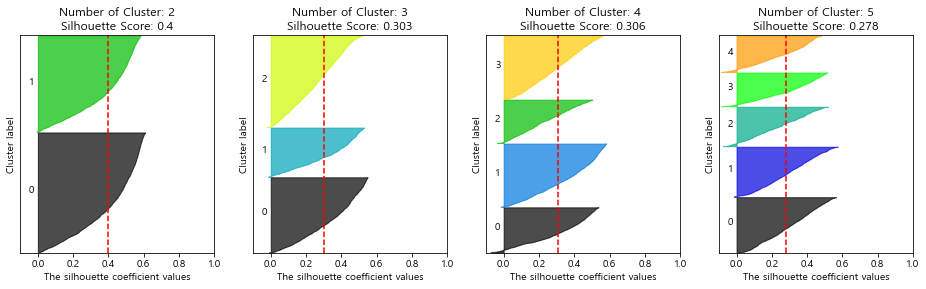

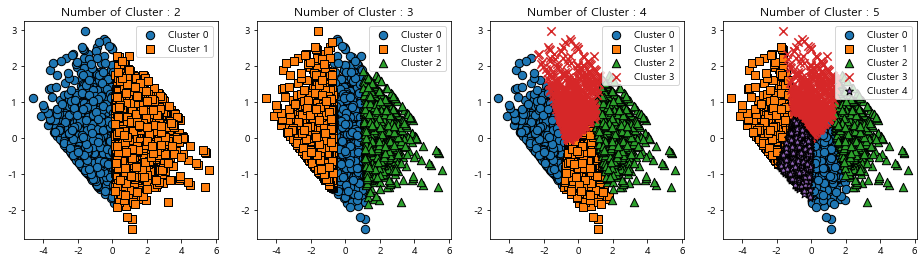

In [75]:
visualize_silhouette([2,3,4,5],X_feature_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_feature_scaled)

- 실루엣 스코어는 로그 변환히기전보다 떨어지지만 앞의 경우보다 더 균일하게 군집화가 구성되었음
- 왜곡된 데이터 세트에 대해서는 로그변환으로 데이터를 일차 변환 후 군집화를 수행하면 더 나은 결과를 도출할 수 있음